# Problem 2

Propose bins for the weight and height considering **all** subjects. Count the number of observations for every possible bin combination. Using the **even-numbered** subjects, fit a Poisson regression model for the counts, using functions of the height and weight as predictors. 

Then, compute the MSE on the number of counts your model predicted for the **odd-numbered** subjects and the observed values for them. Based on your MSE results, is using the Poisson regression a good idea instead of using the raw histogram of the even-numbered subjects directly as a model? (35 points)

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from statsmodels.discrete.discrete_model import Poisson
from sklearn.metrics import mean_squared_error as mse


# Import BMI Data

In [92]:
df = pd.read_excel('bmi_data.xlsx')
df

,Gender,Height,Weight,BMI,Number
0,Male,198,50,12.753801,1
1,Female,198,50,12.753801,2
2,Female,196,50,13.015410,3
3,Female,190,50,13.850416,4
4,Male,190,50,13.850416,5
...,...,...,...,...,...
495,Female,140,146,74.489796,496
496,Male,140,146,74.489796,497
497,Male,145,160,76.099881,498
498,Male,140,152,77.551020,499


# Create bins for height and weight

First, we decide a specific number of bins for height and weight columns, in this specific problem, we choose to have **10 bins** for each one. Thus, a **10x10** grid is created to classify and count each entry of **all** the data.

To define the step values for the height and weight bins, i.e., the range of numbers of each individual bin, the following formula is used:

$$\large Height_{step} = \frac{(Height_{max} - Height_{min} + 1)}{NumberOfBins}$$

$$\large Weight_{step} = \frac{(Weight_{max} - Weight_{min} + 1)}{NumberOfBins}$$

where $Height_{max}$ is the maximum value of the $Height$ column and $Height_{min}$ is the minimum value. The same applies for the $Weight$ column.

In [93]:
#Create bins
height_number_of_bins = 10
weight_number_of_bins = 10

height_range_step = (df['Height'].max() - df['Height'].min() + 1)/height_number_of_bins
weight_range_step = (df['Weight'].max() - df['Weight'].min() + 1)/weight_number_of_bins

print("Height step: " + str(height_range_step))
print("Weight step: " + str(weight_range_step))

Height step: 6.0
Weight step: 11.1


After the **step** is defined, it is possible to calculate the row values that are going to be used for the Poisson Regression.

In [94]:
#Prepare numpy dataframe row values for Poisson Regression
height_bin_values = []
weight_bin_values = []

for i in range(height_number_of_bins):
    height_bin_values.append( df['Height'].min() + height_range_step*i )

for i in range(weight_number_of_bins):
    weight_bin_values.append( df['Weight'].min() + weight_range_step*i )

print("Height bins values: " + str(height_bin_values))
print("Weight bins values: " + str(weight_bin_values))

Height bins values: [140.0, 146.0, 152.0, 158.0, 164.0, 170.0, 176.0, 182.0, 188.0, 194.0]
Weight bins values: [50.0, 61.1, 72.2, 83.3, 94.4, 105.5, 116.6, 127.7, 138.8, 149.89999999999998]


Then, we can identify to which indexes $[row, column]$ correspond to a particular row in the source dataset, considering height bins as rows and weight bins as columns in the matrix **bins_grid**.

Similarly, we create other two matrixes, **bins_grid_even** and **bins_grid_odd** which stores only the count of the dataset entries with **even** column number and **odd** column number respectively.

For that purpose, we implement the following formulas to determine the row ($Height_{idx}$) and column ($Weight_{idx}$) matrix indexes for a particular entry in the data:

$$\large Height_{idx} = \left \lfloor{ \frac{Height_{val} - Height_{min}}{Height_{step}} }\right \rfloor $$
$$\large Weight_{idx} = \left \lfloor{ \frac{Weight_{val} - Weight_{min}}{Weight_{step}} }\right \rfloor $$

where $Height_{val}$ and $Weight_{val}$ are the particular column values of a row in the BMI dataset.


In [95]:
#Create grid of bins
grid_dim  = (height_number_of_bins, weight_number_of_bins)
bins_grid = np.zeros(grid_dim)
bins_grid_even = np.zeros(grid_dim)
bins_grid_odd  = np.zeros(grid_dim)

height_column = df['Height']
weight_column = df['Weight']
number_column = df['Number']

for i in range(df.shape[0]):
    grid_bin_height_idx = int(( height_column[i] - df['Height'].min() ) // height_range_step)
    grid_bin_weight_idx = int(( weight_column[i] - df['Weight'].min() ) // weight_range_step)
    bins_grid[grid_bin_height_idx][grid_bin_weight_idx] += 1

    #Even count
    if number_column[i] % 2 == 0:
        bins_grid_even[grid_bin_height_idx][grid_bin_weight_idx] += 1
    #Odd count
    else:
        bins_grid_odd[grid_bin_height_idx][grid_bin_weight_idx] += 1

print('Height-Weight Count Grid:')
display(bins_grid)
print('Even Height-Weight Count Grid:')
display(bins_grid_even)
print('Odd Height-Weight Count Grid:')
display(bins_grid_odd)

Height-Weight Count Grid:


array([[ 1.,  3.,  7.,  8.,  1.,  2.,  3.,  6.,  8.,  3.],
       [ 7.,  8.,  2.,  6.,  5.,  4.,  3.,  1.,  4.,  5.],
       [ 9.,  3.,  5.,  3.,  7.,  9.,  2.,  4.,  6.,  2.],
       [ 4.,  4.,  3.,  1.,  6.,  4.,  6.,  5.,  5.,  9.],
       [ 7.,  7.,  5.,  5.,  6.,  4.,  4.,  4., 10.,  8.],
       [ 2.,  3.,  4.,  4.,  6.,  7.,  3.,  4.,  6.,  3.],
       [10.,  3.,  9.,  4.,  4.,  7.,  9.,  2.,  5.,  9.],
       [ 5.,  4.,  8.,  8.,  8.,  3.,  7.,  8., 11.,  7.],
       [ 7.,  5.,  5.,  3.,  9.,  3.,  5.,  4.,  4.,  2.],
       [ 4.,  4.,  1.,  2.,  4.,  7.,  4.,  3.,  3.,  4.]])

Even Height-Weight Count Grid:


array([[1., 1., 2., 2., 1., 1., 2., 1., 5., 2.],
       [2., 3., 0., 2., 3., 3., 3., 1., 3., 2.],
       [6., 3., 2., 3., 4., 2., 0., 3., 2., 1.],
       [2., 2., 3., 0., 1., 4., 5., 3., 3., 5.],
       [6., 2., 3., 3., 3., 3., 2., 2., 3., 1.],
       [1., 1., 2., 3., 4., 4., 3., 2., 4., 2.],
       [5., 1., 6., 3., 0., 3., 4., 2., 2., 4.],
       [2., 0., 4., 6., 1., 2., 5., 2., 5., 4.],
       [3., 3., 2., 0., 4., 2., 2., 3., 2., 1.],
       [1., 3., 0., 1., 3., 3., 3., 1., 2., 2.]])

Odd Height-Weight Count Grid:


array([[0., 2., 5., 6., 0., 1., 1., 5., 3., 1.],
       [5., 5., 2., 4., 2., 1., 0., 0., 1., 3.],
       [3., 0., 3., 0., 3., 7., 2., 1., 4., 1.],
       [2., 2., 0., 1., 5., 0., 1., 2., 2., 4.],
       [1., 5., 2., 2., 3., 1., 2., 2., 7., 7.],
       [1., 2., 2., 1., 2., 3., 0., 2., 2., 1.],
       [5., 2., 3., 1., 4., 4., 5., 0., 3., 5.],
       [3., 4., 4., 2., 7., 1., 2., 6., 6., 3.],
       [4., 2., 3., 3., 5., 1., 3., 1., 2., 1.],
       [3., 1., 1., 1., 1., 4., 1., 2., 1., 2.]])

# Translation to a pd DataFrame for **Poisson Regression**

In order to fit the poisson regression model, for each matrix grid, we generate rows that correspond to every possible pair combination of a height and a weight bin which directly corresponds to every entry in the **10x10** matrix, therefore, our new dataframe will consist of **3** columns and **100** rows. Again, we create a dataframe for all the data and other two for only **even** or **odd** values respectively.



In [96]:
bmi_data      = []
bmi_data_even = []
bmi_data_odd  = []

for i in range(height_number_of_bins):
    for j in range(weight_number_of_bins):
        bmi_data.append([ height_bin_values[i], weight_bin_values[j], bins_grid[i][j] ])
        bmi_data_even.append([ height_bin_values[i], weight_bin_values[j], bins_grid_even[i][j] ])
        bmi_data_odd.append([ height_bin_values[i], weight_bin_values[j], bins_grid_odd[i][j] ])

#Create DataFrame for all data
bmi_df = pd.DataFrame(bmi_data, columns = ['Height', 'Weight', 'Count'])
#Create DataFrame for data in even positions
bmi_df_even = pd.DataFrame(bmi_data_even, columns = ['Height', 'Weight', 'Count'])
#Create DataFrame for data in odd positions
bmi_df_odd = pd.DataFrame(bmi_data_odd, columns = ['Height', 'Weight', 'Count'])

print("BMI DataFrame: ")
display(bmi_df)
print("Even BMI DataFrame: ")
display(bmi_df_even)
print("Odd BMI DataFrame: ")
display(bmi_df_odd)

BMI DataFrame: 


,Height,Weight,Count
0,140.0,50.0,1.0
1,140.0,61.1,3.0
2,140.0,72.2,7.0
3,140.0,83.3,8.0
4,140.0,94.4,1.0
...,...,...,...
95,194.0,105.5,7.0
96,194.0,116.6,4.0
97,194.0,127.7,3.0
98,194.0,138.8,3.0


Even BMI DataFrame: 


,Height,Weight,Count
0,140.0,50.0,1.0
1,140.0,61.1,1.0
2,140.0,72.2,2.0
3,140.0,83.3,2.0
4,140.0,94.4,1.0
...,...,...,...
95,194.0,105.5,3.0
96,194.0,116.6,3.0
97,194.0,127.7,1.0
98,194.0,138.8,2.0


Odd BMI DataFrame: 


,Height,Weight,Count
0,140.0,50.0,0.0
1,140.0,61.1,2.0
2,140.0,72.2,5.0
3,140.0,83.3,6.0
4,140.0,94.4,0.0
...,...,...,...
95,194.0,105.5,4.0
96,194.0,116.6,1.0
97,194.0,127.7,2.0
98,194.0,138.8,1.0


# Poisson Regression

Once we obtain the dataframe, we create 3 new columns for the even and odd dataframes respectively. This correspond to the squared height ($Height^2$), the squared weight ($Weight^2$) and the product of both ($Height \cdot Weight$). This values will enrich the poisson regression model to get a better fit estimation.


In [97]:
# Adding variables to the even-numbered data
bmi_df_even['h^2'] = bmi_df_even['Height']**2
bmi_df_even['w^2'] = bmi_df_even['Weight']**2
bmi_df_even['hw'] = bmi_df_even['Height'] * bmi_df_even['Weight']

# Adding variables to the odd-numbered data
bmi_df_odd['h^2'] = bmi_df_odd['Height']**2
bmi_df_odd['w^2'] = bmi_df_odd['Weight']**2
bmi_df_odd['hw'] = bmi_df_odd['Height'] * bmi_df_odd['Weight']

print("Even BMI DataFrame: ")
display(bmi_df_even)
print("Odd BMI DataFrame: ")
display(bmi_df_odd)


Even BMI DataFrame: 


,Height,Weight,Count,h^2,w^2,hw
0,140.0,50.0,1.0,19600.0,2500.00,7000.0
1,140.0,61.1,1.0,19600.0,3733.21,8554.0
2,140.0,72.2,2.0,19600.0,5212.84,10108.0
3,140.0,83.3,2.0,19600.0,6938.89,11662.0
4,140.0,94.4,1.0,19600.0,8911.36,13216.0
...,...,...,...,...,...,...
95,194.0,105.5,3.0,37636.0,11130.25,20467.0
96,194.0,116.6,3.0,37636.0,13595.56,22620.4
97,194.0,127.7,1.0,37636.0,16307.29,24773.8
98,194.0,138.8,2.0,37636.0,19265.44,26927.2


Odd BMI DataFrame: 


,Height,Weight,Count,h^2,w^2,hw
0,140.0,50.0,0.0,19600.0,2500.00,7000.0
1,140.0,61.1,2.0,19600.0,3733.21,8554.0
2,140.0,72.2,5.0,19600.0,5212.84,10108.0
3,140.0,83.3,6.0,19600.0,6938.89,11662.0
4,140.0,94.4,0.0,19600.0,8911.36,13216.0
...,...,...,...,...,...,...
95,194.0,105.5,4.0,37636.0,11130.25,20467.0
96,194.0,116.6,1.0,37636.0,13595.56,22620.4
97,194.0,127.7,2.0,37636.0,16307.29,24773.8
98,194.0,138.8,1.0,37636.0,19265.44,26927.2


## Fit

For the poisson fit specifically, we feed the dataframe corresponding to the even-numbered values.

In [98]:
# Poisson Regression to even-numbered data
poi_fit_even = Poisson(bmi_df_even['Count'], bmi_df_even[['Height','Weight','h^2','w^2','hw']]).fit()

Optimization terminated successfully.
         Current function value: 1.754953
         Iterations 6


## Predict

Then we use the model to make predictions with the odd-numbered values.

In [99]:
# Prediction of odd-numbered data with the even-numbered data Poisson Regression model fit
bmi_df_odd['Poi_Predict'] = poi_fit_even.predict(bmi_df_odd[['Height','Weight','h^2','w^2','hw']])

Finally, we put together the predicted **poisson model** in contrast to using the **even-numbered values** as a estimator itself.

In [100]:
# Generating a dataframe with odd-numbered counts observed, predicted and even counts
count_df = pd.DataFrame(bmi_df_odd, columns=['Height','Weight','Count', 'Poi_Predict'])
count_df.rename(columns={'Count':'Odd Counts', 'Poi_Predict':'Odd Predicted (w/ Even model fit)'}, inplace=True)
count_df['Even Counts'] = bmi_df_even['Count']
count_df

,Height,Weight,Odd Counts,Odd Predicted (w/ Even model fit),Even Counts
0,140.0,50.0,0.0,2.630866,1.0
1,140.0,61.1,2.0,2.518908,1.0
2,140.0,72.2,5.0,2.429474,2.0
3,140.0,83.3,6.0,2.360469,2.0
4,140.0,94.4,0.0,2.310312,1.0
...,...,...,...,...,...
95,194.0,105.5,4.0,2.431182,3.0
96,194.0,116.6,1.0,2.523756,3.0
97,194.0,127.7,2.0,2.639146,1.0
98,194.0,138.8,1.0,2.780134,2.0


# Heatmap visualization

In [101]:
z_obs = np.array(count_df['Odd Counts'].values).reshape(10,10)
z_evn = np.array(count_df['Even Counts'].values).reshape(10,10)
z_vec = np.array(count_df['Odd Predicted (w/ Even model fit)'].values).reshape(10,10)
x_vec = count_df.Height.unique()
y_vec = count_df.Weight.unique()

## Odd-numbered values heatmap

[Text(0, 0, '140.0'),
 Text(0, 0, '146.0'),
 Text(0, 0, '152.0'),
 Text(0, 0, '158.0'),
 Text(0, 0, '164.0'),
 Text(0, 0, '170.0'),
 Text(0, 0, '176.0')]

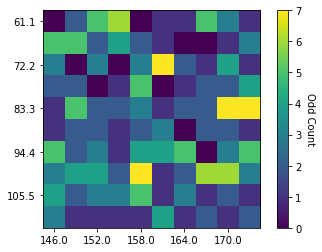

In [102]:
fig, ax    = plt.subplots()
grid_image = ax.imshow(z_obs)

# Create colorbar
cbar = ax.figure.colorbar(grid_image, ax=ax)
cbar.ax.set_ylabel('Odd Count', rotation=-90, va="bottom")

# Set values
ax.set_yticklabels(weight_bin_values)
ax.set_xticklabels(height_bin_values)

## Even-numbered values heatmap

[Text(0, 0, '140.0'),
 Text(0, 0, '146.0'),
 Text(0, 0, '152.0'),
 Text(0, 0, '158.0'),
 Text(0, 0, '164.0'),
 Text(0, 0, '170.0'),
 Text(0, 0, '176.0')]

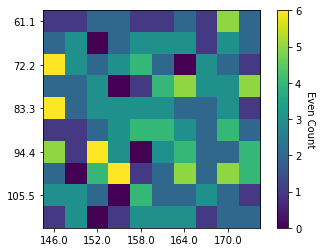

In [103]:
fig, ax    = plt.subplots()
grid_image = ax.imshow(z_evn)

# Create colorbar
cbar = ax.figure.colorbar(grid_image, ax=ax)
cbar.ax.set_ylabel('Even Count', rotation=-90, va="bottom")

# Set values
ax.set_yticklabels(weight_bin_values)
ax.set_xticklabels(height_bin_values)

## Poission Prediction heatmap

[Text(0, 0, '140.0'),
 Text(0, 0, '146.0'),
 Text(0, 0, '152.0'),
 Text(0, 0, '158.0'),
 Text(0, 0, '164.0'),
 Text(0, 0, '170.0'),
 Text(0, 0, '176.0')]

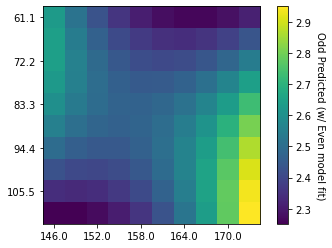

In [104]:
fig, ax    = plt.subplots()
grid_image = ax.imshow(z_vec)

# Create colorbar
cbar = ax.figure.colorbar(grid_image, ax=ax)
cbar.ax.set_ylabel('Odd Predicted (w/ Even model fit)', rotation=-90, va="bottom")

# Set values
ax.set_yticklabels(weight_bin_values)
ax.set_xticklabels(height_bin_values)

# Results and MSE Calculation

In [105]:
# Getting MSE of Observed_odd-numbered_Counts vs Predicted_odd-numbered_Counts_with_even-numbered_data_fit
MSE_oo_po = mse(bmi_df_odd['Count'], bmi_df_odd['Poi_Predict'])

# Getting MSE of Observed_odd-numbered_Counts vs Observed_even-numbered_Counts
MSE_oo_oe = mse(bmi_df_odd['Count'], bmi_df_even['Count'])

(MSE_oo_po, MSE_oo_oe)

(3.2589993745018266, 5.08)

#### Based on the MSE results, we can conclude that the even-numbered subjects data Poisson Regression model (smaller MSE) is a better fit in the odd numbered data than the raw data of even numbered subjects as a model.